In [94]:
from collections import Counter
import itertools

from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as FF
from wordcloud import WordCloud

from config import Config
from risk_detection.utils import get_immediate_subdirectories
from risk_detection.analysis.keyword_extraction import get_keywords

## Filtering Keywords based on the Sentiment of the Context in which it is used.

In [18]:
def analyze_keyword_sentiments(cik, print_stats=False):
    keys = get_keywords(cik)
    
    num_keywords = list()
    num_negative_keywords = list()
    filtered = list()
    
    for key in keys:
        num_keywords.append(len(key.get_keywords()))
        num_negative_keywords.append(len(key.get_negative_keywords()))
        filtered.append(set(key.get_keywords()) - set(key.get_negative_keywords()))
    
    avg_num_keywords = sum(num_keywords) / len(num_keywords)
    avg_num_neg_keywords = sum(num_negative_keywords) / len(num_negative_keywords)
    avg_num_filtered = sum([len(f) for f in filtered]) / len(filtered)
    
    if print_stats:
        print(f'Average Number of all keywords: {avg_num_keywords}')
        print(f'Average Number of negative keywords: {avg_num_neg_keywords}')
        print(f'Average Number of filtered keywords: {avg_num_filtered}')
        print(filtered)
    
    return avg_num_keywords, avg_num_neg_keywords, filtered

In [19]:
ciks = get_immediate_subdirectories(Config.text_rank_keywords_dir())

In [20]:
num_keywords = list()
num_neg_keywords = list()
filtered_keywords = list()

for cik in tqdm(ciks):
    try:
        avg_num_keywords, avg_num_neg_keywords, filtered = analyze_keyword_sentiments(cik)
        num_keywords.append(avg_num_keywords)
        num_neg_keywords.append(avg_num_neg_keywords)
        filtered_keywords.append(filtered)
    except ZeroDivisionError:
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6315/6315 [2:22:05<00:00,  1.35s/it]


In [110]:
import pickle
with open('sentiment_filter_data.pickle', 'wb') as f:
    pickle.dump((num_keywords, num_neg_keywords, filtered_keywords), f, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
avg_num_keywords = sum(num_keywords) / len(num_keywords)
avg_num_neg_keywords = sum(num_neg_keywords) / len(num_neg_keywords)

num_filtered = [np.mean([len(f) for f in fa]) for fa in filtered_keywords]
filtered_words = set().union(*itertools.chain.from_iterable(filtered_keywords))
avg_num_filtered = sum(num_filtered) / len(num_filtered)

In [80]:
print(f'Average Number of all keywords: {avg_num_keywords}')
print(f'Average Number of negative keywords: {avg_num_neg_keywords}')
print(f'Average Number of filtered keywords: {avg_num_filtered}')

Average Number of all keywords: 93.13318940106706
Average Number of negative keywords: 83.890445853364
Average Number of filtered keywords: 9.242743547702931


In [29]:
analyze_keyword_sentiments(1000045)

(94.66666666666667,
 84.55555555555556,
 [{'consumer finance industry',
   'financing companies',
   'interest rate changes',
   'key man life insurance policies',
   'non prime borrowers',
   'non prime consumer finance industry',
   'non prime consumer financing',
   'rate debt'},
  {'consumer finance industry',
   'financing companies',
   'interest rate changes',
   'key man life insurance policies',
   'managers',
   'non prime borrowers',
   'non prime consumer finance industry',
   'non prime consumer financing',
   'rate debt'},
  {'consumer finance industry',
   'financing companies',
   'interest rate changes',
   'key man life insurance policies',
   'managers',
   'prime consumer finance industry',
   'rate debt',
   'senior vice president finance',
   'turnover rate'},
  {'consumer finance industry',
   'efficient vehicles',
   'financing companies',
   'interest rate changes',
   'key man life insurance policies',
   'managers',
   'prime consumer finance industry',
   'r

In [81]:
print(stats.describe(num_keywords))
print(stats.describe(num_neg_keywords))
print(stats.describe(num_filtered))

DescribeResult(nobs=6276, minmax=(1.0, 100.0), mean=93.13318940106703, variance=187.9182071958061, skewness=-5.47587262430118, kurtosis=30.992469423547305)
DescribeResult(nobs=6276, minmax=(1.0, 99.0), mean=83.89044585336411, variance=172.25406319309442, skewness=-4.489836047103344, kurtosis=23.346803080926723)
DescribeResult(nobs=6276, minmax=(0.0, 53.0), mean=9.242743547702917, variance=26.988252025864433, skewness=1.3027152961758317, kurtosis=4.494717942165237)


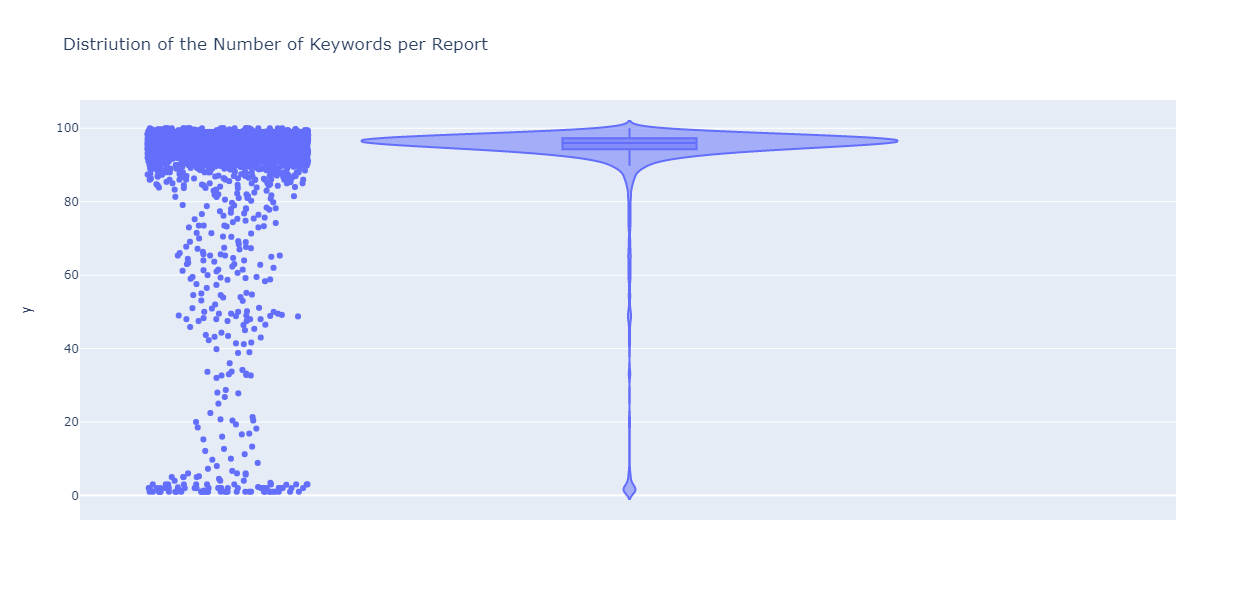

In [57]:
fig = px.violin(
    y=num_keywords, box=True, # draw box plot inside the violin
    points='all', # can be 'outliers', or False
    title='Distriution of the Number of Keywords per Report',
    height=600, width=600
)
fig.show()

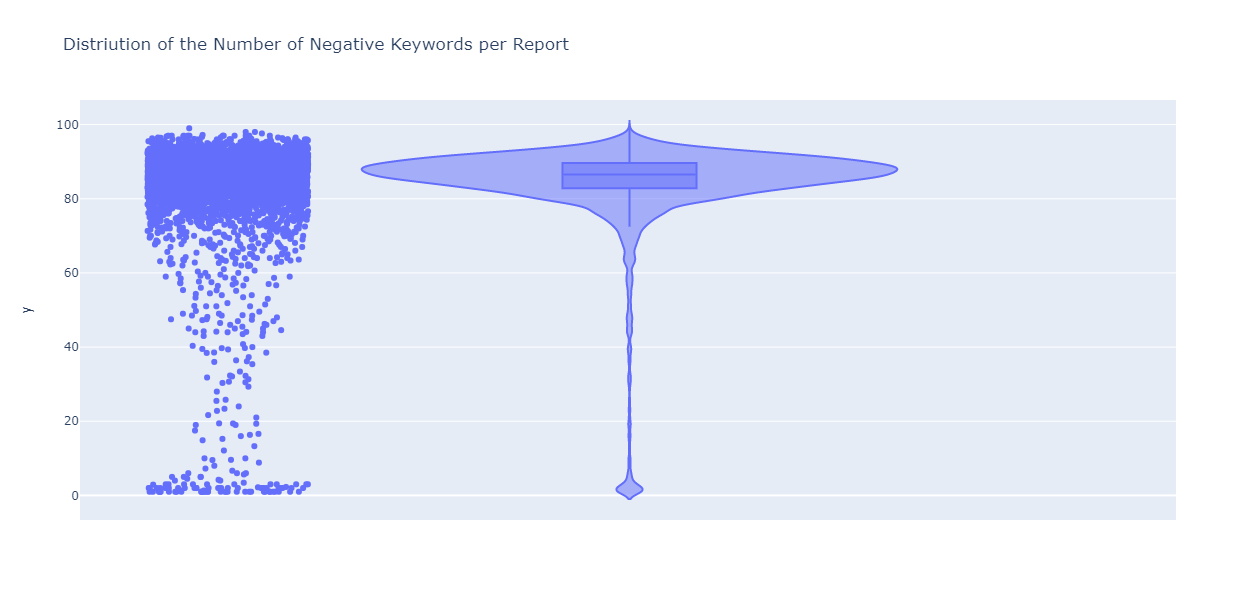

In [58]:
fig = px.violin(
    y=num_neg_keywords, box=True, # draw box plot inside the violin
    points='all', # can be 'outliers', or False
    title='Distriution of the Number of Negative Keywords per Report',
    height=600, width=600
)
fig.show()

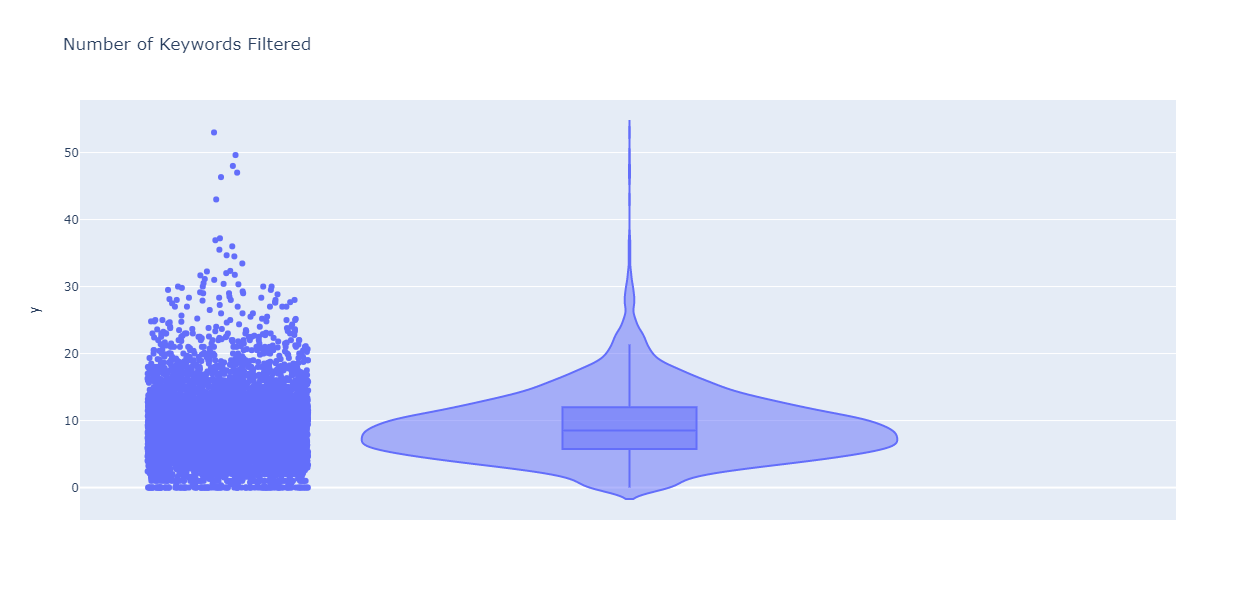

In [82]:
fig = px.violin(
    y=num_filtered, box=True, # draw box plot inside the violin
    points='all', # can be 'outliers', or False
    title='Number of Keywords Filtered',
    height=600, width=600
)
fig.show()

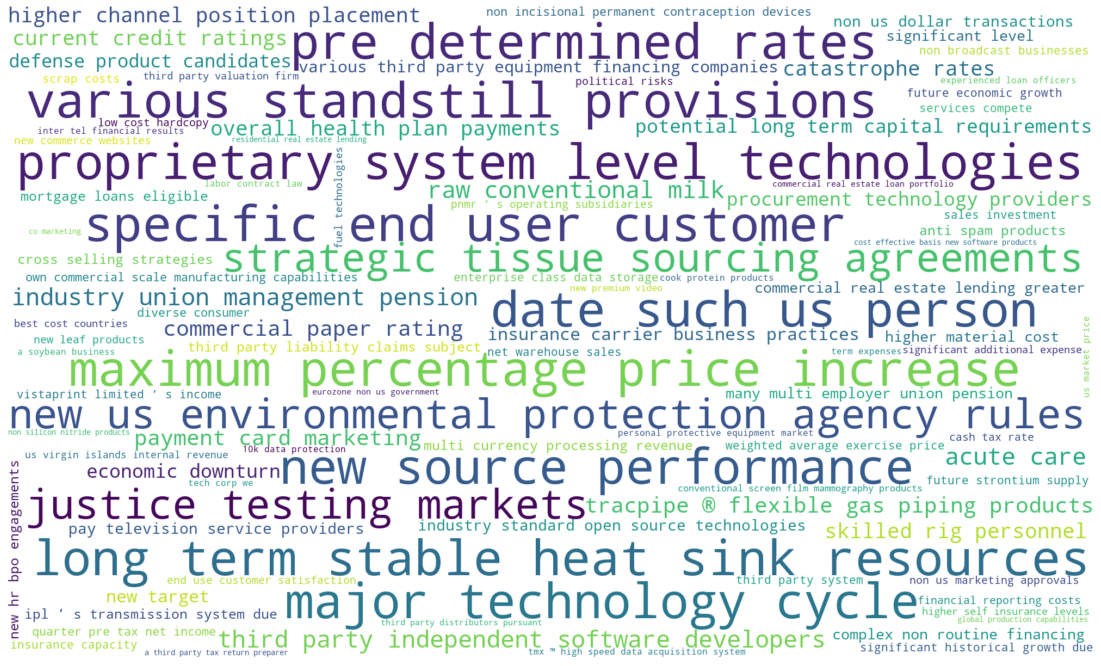

In [105]:
wc = WordCloud(
    width=2000,
    height=1200,
    background_color="white",
    stopwords=set(),
    max_words=100,
    max_font_size=90,
    random_state=42,
    contour_width=1,
    contour_color="#119DFF",
)
wc.generate_from_frequencies(Counter(filtered_words))
fig = plt.figure(figsize=[20, 12])
ax = plt.imshow(wc.recolor(), interpolation="bilinear")
plt.axis("off")
plt.savefig('plots\\filtered_keywords.jpg', bbox_inches='tight')
plt.show()

In [108]:
print(f'Number of filtered keywords: {len(filtered_words)}')

Number of filtered keywords: 78464


# Test plots

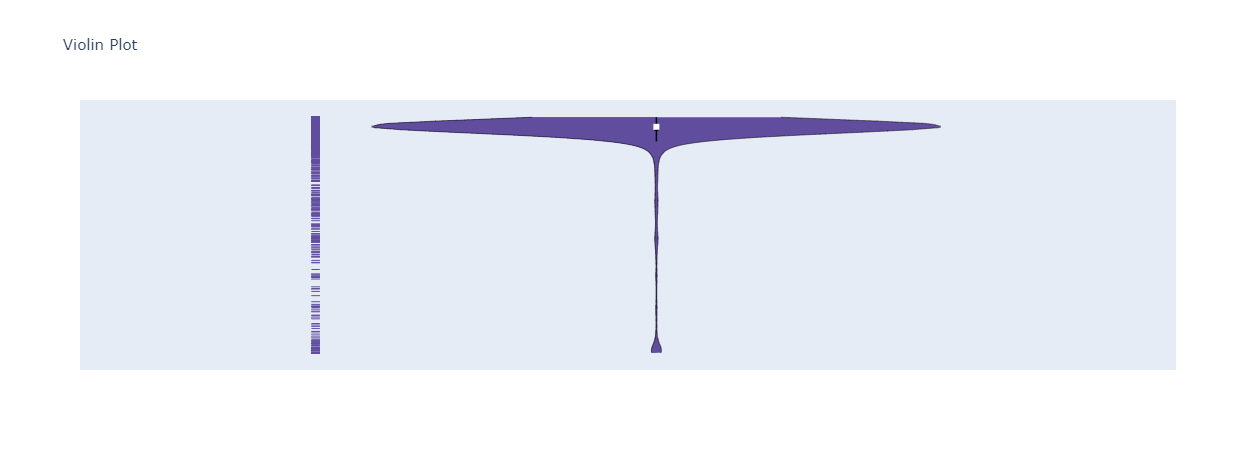

In [42]:
fig = FF.create_violin(num_keywords, title='Violin Plot', colors='#604d9e')
fig.show()

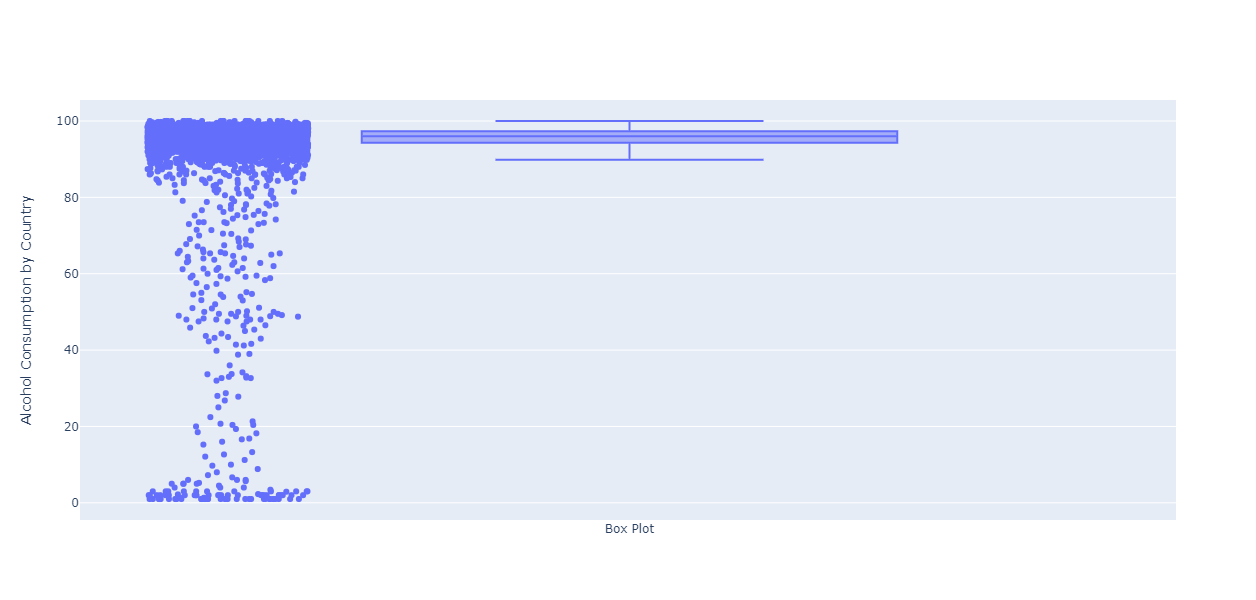

In [51]:
y = num_keywords

trace = go.Box(
    y=y,
    name = 'Box Plot',
    boxpoints='all',
    jitter=0.3,
#     marker = dict(
#         color = 'rgb(214,12,140)',
#     ),
)

layout = go.Layout(
    height=600,
    width=600,
    yaxis=dict(
        title='Alcohol Consumption by Country',
        zeroline=False
    ),
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.show()